- Student Name: Xiuwen (Alice) Zhu
- Student ID: 1149188
- Course Code: COMP647
- Course Examiner: Professor Don Kulasiri
- Due Date: 03/11/2025

# Project Plan

1.	Feature engineering and feature selection as appropriate to your dataset. Briefly explain and justify what you do using comments in your Python code. *(Feature engineering and feature selection was completed in assignment 2, so I will go straight to plan 2. )*

2.	Use appropriate machine learning algorithms (supervised and/or unsupervised) to perform forecasting, classification or clustering tasks with respect to your dataset. Justify why the respective algorithms are selected.
3.	Conduct performance measures in the algorithm evaluations and justify the selected the performance measures would be the most appropriate to evaluate the algorithms chosen. 
4.	Explain how you avoid over fitting and underfitting of the algorithms. 
5.	Perform appropriate eXplainable AI techniques to discover which features are influencing the predictions


# Research Questions

**As an entrepreneur, I want to know:**
Which sub-categories will have better sales based on their current sale, number of reviews and rating. 

**As a buyer, I want to know:**
Which sellers have received more consistent high ratings for their products?

**As the company, I want to know:**
What are the main factors of the sold products that may be contributing to the variation in sales?



# Import the Neccessary Libaries for Machine Learning

In [73]:
import itertools
import numpy as np, pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns    
import hdbscan  
from scipy.spatial.distance import cdist         
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import IsolationForest


# Read Data from CSV

In [74]:
file_path = 'cleaned_amazon_ecommerce.csv' # Define the file path for the dataset.
df = pd.read_csv (file_path)

# View Data

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9983 entries, 0 to 9982
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   uniq_id                         9983 non-null   object 
 1   product_name                    9983 non-null   object 
 2   number_of_reviews               9983 non-null   int64  
 3   cleaned_price                   9983 non-null   float64
 4   stock_quantity                  9983 non-null   int64  
 5   stock_condition                 9983 non-null   object 
 6   average_review_rating_out_of_5  9983 non-null   float64
 7   main_category                   9983 non-null   object 
 8   sub_category                    9983 non-null   object 
 9   item_weight_in_kg               9983 non-null   float64
 10  recommended_minimum_age_years   9983 non-null   float64
 11  purchase_month                  9983 non-null   int64  
 12  purchase_year                   99

In [76]:
df.head(2)

,uniq_id,product_name,number_of_reviews,cleaned_price,stock_quantity,stock_condition,average_review_rating_out_of_5,main_category,sub_category,item_weight_in_kg,recommended_minimum_age_years,purchase_month,purchase_year,seller_name,main_category_encoded,sub_category_encoded,seller_name_encoded,sales,month_sin,month_cos
0,eac7efa5dbd3d667f26eb3d3ab504464,Hornby 2014 Catalogue,15,3.42,5,new,4.9,Hobbies,Model Trains & Railway Sets,0.6,6.0,4,2014,Amazon.co.uk,17,81,84,17.10,8.660254e-01,-0.5
1,b17540ef7e86e461d37f3ae58b7b72ac,FunkyBuys® Large Christmas Holiday Express Fes...,2,16.99,3,new,4.5,Hobbies,Model Trains & Railway Sets,0.2,3.0,12,2015,UHD WHOLESALE,17,81,1588,50.97,-2.449294e-16,1.0


# Research Question 1

Which sub-categories span from 2001 to 2016 have had good sale performance in November based on their number of reviews and rating?

In [77]:
# I want to analyse product sales in November using the previous November data, because this is when festive season shopping starts.
# Although low review count does not means low sale, high review count usually means high sales.
# Therefore, I will use review_count as a proxy for sales.
# Also because this is an analysis of sales over years, an unsupervised ML model will be used to cluster the sub-categorries.
# A KMeans model will be used, as it can cluster data points based on feature similarity using the mean of number of reviews and ratings.

nov = df[df['purchase_month'] == 11].copy()

In [78]:
# Aggregate necessary statistics for November data for each sub-category.

agg = (
    nov
    .groupby('sub_category')
    .agg(
        mean_reviews=('number_of_reviews', 'mean'), # Proxy for popularity.
        std_reviews=('number_of_reviews', 'std'), # Consistency of popularity.
        #median_reviews=('number_of_reviews', 'median'), # Consistency of popularity.
        #mean_rating=('average_review_rating_out_of_5', 'mean'), # Proxy for quality.
        count_years=('purchase_year', 'nunique'), # Years being sold in November.
    )
    .reset_index()
)
agg['std_reviews'] = agg['std_reviews'].fillna(0)

In [80]:
# Compute the trend of number_of_reviews over years for each sub-category.

#def compute_trend(g):
    #if g['purchase_year'].nunique() < 2: 
        return 0.0 # Return zero trend if the purchase year data is less than 2 years.
    #x = g['purchase_year'].values.astype(float) # Range of years for that sub-category.
    #y = g['number_of_reviews'].values.astype(float) # Corresponding review counts for each year.
    #A = np.vstack([x, np.ones(len(x))]).T # This is to set up the linear regression problem.
    #slope, _ = np.linalg.lstsq(A, y, rcond=None)[0] # The lstsq function finds the best fit line y = slope * x + intercept.
    return float(slope)

#trend = nov.groupby('sub_category').apply(compute_trend).rename('trend_reviews_per_year').reset_index()
# nov.groupby('sub_category') function groups the data by sub-category.
#agg = agg.merge(trend, on='sub_category', how='left')
#agg['trend_reviews_per_year'] = agg['trend_reviews_per_year'].fillna(0.0)

IndentationError: unindent does not match any outer indentation level (<string>, line 10)

In [84]:
# Preprocess features: cap extreme values and apply log1p transformation to skwed data.
# KMean clustering assumes normal distributed data and is sensitive to outliers. 
# So the purpose of this step is to reduce the influence of outliers and normallise the skewed distributions, so that the clustering algorithm can perform effectively.
# Upon the capping and log-transforming, the data will be normalised and dominant features will be scaled down.

cols_cap_log = ['std_reviews'] # Define which columns to cap and log-transform.
agg2 = agg.copy() # Create a copy of the aggregated data, so that the origianl data is preserved. 
for c in cols_cap_log: 
    cap = agg2[c].quantile(0.99) # Capping to keep 99% of the data unaffected, but the 1% extreme outliers will be compressed.
    agg2[c] = np.minimum(agg2[c].fillna(0), cap) 
    agg2[c] = np.log1p(agg2[c]) # Compress distribution with log1p function to reduce skewness.

In [85]:
features = ['std_reviews','count_years'] # Feature selection for clustering.
X = agg2[features].fillna(0).values 

# KMeans does not work with df, but numeric matrices, so this assigned X will correspond to one sub-category per row and each feature per column.
# This will apply to the extract feature values and fill any remaining NaNs with 0.
scaler = StandardScaler() # Normaling the features so that they are all on the same scale.
X_scaled = scaler.fit_transform(X) # Calculate and apply the scaling.

In [89]:
# Determine the optimal number of clusters (k) using silhouette score.
# Silhouette score measures how similar an object is to its own cluster compared to other clusters.
# A higher silhouette score indicates better-defined clusters, so the highest K will be chosen.
# 

scores = {}
for k in range(2,12): 
    # Test k values from 2 to 5. The reason that it starts from 2 is that if it is 1, then all data points are in 1 cluster.
    km = KMeans(n_clusters=k, random_state=42, n_init=50) 
    # n_clusters=k sets the number of clusters.
    # random_state=42 ensures reproducibility of results.
    # n_init=50 means runs the algorithm will run 50 times with different starting points, and keeping the best solution.
    labels = km.fit_predict(X_scaled)
    # Fit the KMeans model to the scaled data.
    scores[k] = silhouette_score(X_scaled, labels)
    # Calculate silhouette score for the cluster and store it in the scores dictionary.
    print(f"k={k} -> silhouette {scores[k]:.4f}")

best_k = max(scores, key=scores.get)
print("Best k by silhouette:", best_k)


# Silhouette score range from -1 to 1. A score close to 1 indicates that the samples are far away from the neighboring clusters, which is a good clustering result.
# A score of 0 means clusters are overlapping.
# A negative score indicates that samples might have been assigned to the wrong cluster.
# I have explored multiple k values ranges and found that k=5 gives the highest silhouette score of 0.4184.
# However, the clusters are not well defined.
# When I tried K=4, where the silhouette score is slightly lower at 0.3767, the clusters are better defined than k=5.
# Despite K=4 gives more defined clusters, the silhouette score is not very high, meaning that the clusters are not very distinct.
# Therefore, I need to adjust my feature selection and preprocessing steps to improve the clustering results.
# After dropping the mean_rating and median_reviews features, the silhouette score improved to 0.4926 at k=4.
# This indicates those two features adds variance and noises, not helping with reinforcing the separation between clusters.

k=2 -> silhouette 0.6134
k=3 -> silhouette 0.5298
k=4 -> silhouette 0.5208
k=5 -> silhouette 0.5342
k=6 -> silhouette 0.5292
k=7 -> silhouette 0.5283
k=8 -> silhouette 0.5464
k=9 -> silhouette 0.5709
k=10 -> silhouette 0.5727
k=11 -> silhouette 0.5826
Best k by silhouette: 2


In [87]:
def eval_labels(X, labels):
    return {
        'silhouette': silhouette_score(X, labels) if len(set(labels))>1 else -1,
        'calinski_harabasz': calinski_harabasz_score(X, labels) if len(set(labels))>1 else -1,
        'davies_bouldin': davies_bouldin_score(X, labels) if len(set(labels))>1 else np.inf
    }

print(eval_labels(X_scaled, labels)) 


{'silhouette': 0.5342459965635983, 'calinski_harabasz': 188.2671448484265, 'davies_bouldin': 0.7359184275455091}


In [90]:
km = KMeans(n_clusters=best_k, random_state=42, n_init=50).fit(X_scaled)
dists = np.min(cdist(X_scaled, km.cluster_centers_), axis=1)
# n_clusters=best_k means uses the best k value found from previous step, which is k=4.
# random_state=42 means fixes the random initialisation so that the results are reproducible.
# n_init=50 means runs the algorithm 50 times with different starting points, and keeping the best solution.

# remove top 2.5% largest distances
thr = np.quantile(dists, 0.975)
mask = dists <= thr
X_trim = X_scaled[mask]
# re-run clustering on X_trim


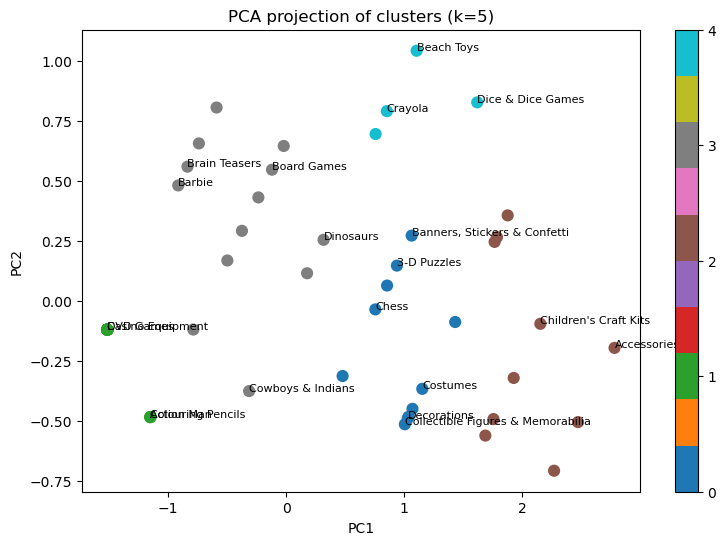

In [101]:
features = ['std_reviews', 'count_years']

# Re-scale using only cleaned data
X = agg_clean[features].fillna(0).values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Run KMeans again on the cleaned data
best_k = 5  # or whatever number of clusters you previously found best
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=50)
agg_clean['cluster'] = kmeans.fit_predict(X_scaled)

# Now run PCA on the same scaled data
pca = PCA(n_components=2, random_state=42)
proj = pca.fit_transform(X_scaled)

# ✅ Shapes now match: len(proj) == len(agg_clean)
plt.figure(figsize=(9,6))
scatter = plt.scatter(proj[:,0], proj[:,1], c=agg_clean['cluster'], cmap='tab10', s=60)
plt.title(f"PCA projection of clusters (k={best_k})")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(scatter, ticks=range(best_k))

# Annotate first 20 points only
for i, txt in enumerate(agg_clean['sub_category'][:20].values):
    plt.annotate(txt, (proj[i,0], proj[i,1]), fontsize=8)

plt.show()

In [99]:
# Get the feature names again
features = ['std_reviews','count_years']

# PCA loadings (weights)
loadings = pd.DataFrame(pca.components_.T, 
                        columns=['PC1', 'PC2'], 
                        index=features)

print(loadings)

                  PC1       PC2
std_reviews  0.707107  0.707107
count_years  0.707107 -0.707107


In [100]:
print("\nCluster sizes:")
print(agg2['cluster'].value_counts().sort_index())

# Which cluster has highest average mean_reviews?
cluster_means = agg2.groupby('cluster')['mean_reviews'].mean().reset_index().sort_values('mean_reviews', ascending=False)
print("\nClusters sorted by avg (log1p) mean_reviews:")
print(cluster_means.to_string(index=False))

# For human-friendly output, show top sub-categories (original mean_reviews scale)
display_columns = ['sub_category','mean_reviews','count_years']
# remember: mean_reviews currently in log1p form — convert back for ranking display
agg_display = agg2.copy()
for c in ['std_reviews']:
    agg_display[c] = np.expm1(agg_display[c])  # inverse of log1p

top_by_cluster = agg_display.sort_values(['cluster','mean_reviews'], ascending=[True, False]).groupby('cluster').head(10)
print("\nTop 10 sub-categories per cluster (by mean_reviews):")
print(top_by_cluster[display_columns].to_string(index=False))



Cluster sizes:


KeyError: 'cluster'

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_11409/1214572183.py:20: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = nov.groupby('sub_category').apply(compute_trend).rename('trend_reviews_per_year').reset_index()


(0.08636375930050136, 11.388602489087853, 1.4645627663835254)
       method  k  silhouette  calinski_harabasz  davies_bouldin
       kmeans  4    0.492598          71.381961        0.700324
agglomerative  4    0.449917          62.706976        0.741771
       kmeans  3    0.441269          59.451449        0.839377
       kmeans  2    0.424146          60.252714        0.962434
agglomerative  2    0.416676          59.422339        0.980367
agglomerative  3    0.407117          53.533660        0.860614
          gmm  2    0.323575          39.228211        1.089360
          gmm  4    0.259789          46.622837        1.186368
          gmm  3    0.213174          35.808306        1.342311
Best method: kmeans k= 4


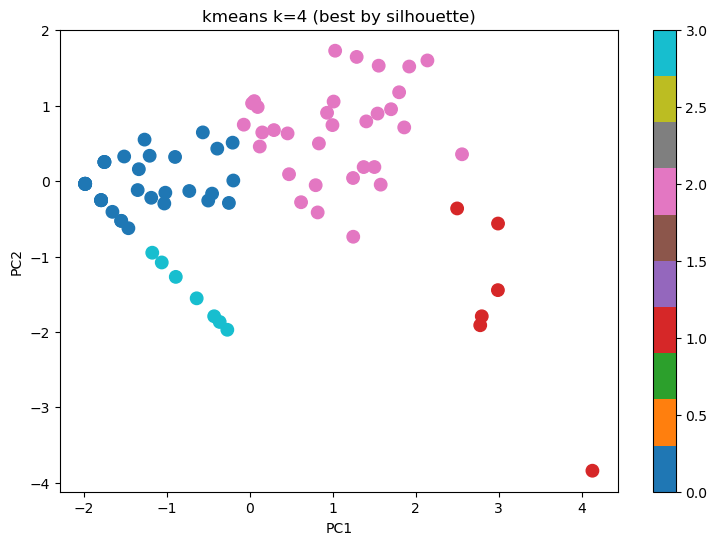

Saved 'nov_clusters_fast_assignments.csv' and 'best_clustering_fast.png'.


In [ ]:
agg = (
    nov.groupby('sub_category')
       .agg(mean_reviews=('number_of_reviews','mean'),
            std_reviews=('number_of_reviews','std'),
            #mean_rating=('average_review_rating_out_of_5','mean'),
            count_years=('purchase_year','nunique'))
       .reset_index()
)
agg['std_reviews'] = agg['std_reviews'].fillna(0)


# 4) preprocess: cap 99th and log1p (on review based cols)
for c in ['mean_reviews','std_reviews']:
    cap = agg[c].quantile(0.99)
    agg[c] = np.minimum(agg[c].fillna(0), cap)
    agg[c] = np.log1p(agg[c])

# 5) features
features = ['mean_reviews','std_reviews','count_years','trend_reviews_per_year']
X = agg[features].fillna(0).values
X_scaled = StandardScaler().fit_transform(X)

# helper
def eval_labels(Xm, labels):
    if len(set(labels)) <= 1:
        return (-1, -1, float('inf'))
    return (silhouette_score(Xm, labels),
            calinski_harabasz_score(Xm, labels),
            davies_bouldin_score(Xm, labels))
print(eval_labels(X_scaled, labels)) 

# 6) try algorithms k=2..4
results = []
for k in range(2,5):
    # KMeans
    km = KMeans(n_clusters=k, random_state=42, n_init=20).fit(X_scaled)
    s,ch,db = eval_labels(X_scaled, km.labels_)
    results.append(('kmeans', k, s, ch, db))
    # GMM
    gmm = GaussianMixture(n_components=k, random_state=42, n_init=3).fit(X_scaled)
    labs = gmm.predict(X_scaled)
    s,ch,db = eval_labels(X_scaled, labs)
    results.append(('gmm', k, s, ch, db))
    # Agglomerative
    aggclus = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X_scaled)
    s,ch,db = eval_labels(X_scaled, aggclus.labels_)
    results.append(('agglomerative', k, s, ch, db))

res = pd.DataFrame(results, columns=['method','k','silhouette','calinski_harabasz','davies_bouldin'])
print(res.sort_values(['silhouette','calinski_harabasz','davies_bouldin'], ascending=[False,False,True]).to_string(index=False))

# 7) pick best by silhouette and refit, save CSV + PCA plot
best = res.sort_values(['silhouette','calinski_harabasz','davies_bouldin'], ascending=[False,False,True]).iloc[0]
method, k = best['method'], int(best['k'])
print("Best method:", method, "k=", k)
if method == 'kmeans':
    model = KMeans(n_clusters=k, random_state=42, n_init=50).fit(X_scaled); labs = model.labels_
elif method == 'gmm':
    model = GaussianMixture(n_components=k, random_state=42, n_init=5).fit(X_scaled); labs = model.predict(X_scaled)
else:
    model = AgglomerativeClustering(n_clusters=k, linkage='ward').fit(X_scaled); labs = model.labels_

agg['cluster'] = labs
agg['mean_reviews_original'] = np.expm1(agg['mean_reviews'])
agg.to_csv("nov_clusters_fast_assignments.csv", index=False)

pca = PCA(n_components=2, random_state=42).fit_transform(X_scaled)
plt.figure(figsize=(9,6))
plt.scatter(pca[:,0], pca[:,1], c=labs, cmap='tab10', s=80)
plt.title(f"{method} k={k} (best by silhouette)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar()
plt.savefig("best_clustering_fast.png", dpi=150)
plt.show()

print("Saved 'nov_clusters_fast_assignments.csv' and 'best_clustering_fast.png'.")

/var/folders/d0/xkmp50cn5p19ts1h16db856r0000gn/T/ipykernel_11409/1258160966.py:25: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trend = nov.groupby('sub_category').apply(compute_trend).rename('trend_reviews_per_year').reset_index()


Per-feature IQR: keeping 79 of 80 rows after IQR filtering.
IsolationForest flagged 21 outliers (multivariate) out of 80
After combining IQR + IsolationForest, keeping 59 rows out of 80

Removed sub-categories (showing up to 30):
                     sub_category  mean_reviews  std_reviews  count_years  trend_reviews_per_year
                         Art Sand      2.335375     2.389951            3                4.195122
                      Blackboards      3.970292     0.000000            1                0.000000
                       Card Games      2.811186     3.260054            7               -4.097868
                        Chocolate      4.304335     0.000000            1                0.000000
         Colouring Pens & Markers      3.338139     3.739746            3               -9.333333
                           Disney      2.378423     3.325703            5              -12.612150
            Dominoes & Tile Games      2.871680     3.590023            6           

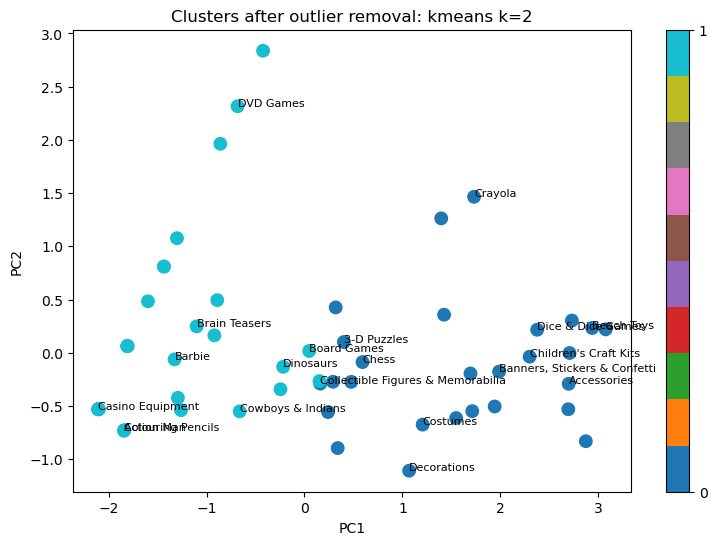

In [ ]:
agg = (
    nov
    .groupby('sub_category')
    .agg(
        mean_reviews=('number_of_reviews', 'mean'),
        #median_reviews=('number_of_reviews', 'median'),
        std_reviews=('number_of_reviews', 'std'),
        #mean_rating=('average_review_rating_out_of_5', 'mean'),
        count_years=('purchase_year', 'nunique')
    )
    .reset_index()
)
agg['std_reviews'] = agg['std_reviews'].fillna(0)     # replace NaN std with 0 for categories with single year


# ---------- 3) preprocessing: cap 99th percentile & log1p for skewed features ----------
# choose review-related features to transform (do NOT include mean_rating or count_years here)
cols_cap_log = ['mean_reviews', 'std_reviews']
agg_proc = agg.copy()                                 # work on a copy

for c in cols_cap_log:
    cap = agg_proc[c].quantile(0.99)                  # compute 99th percentile cap
    agg_proc[c] = np.minimum(agg_proc[c].fillna(0), cap)  # cap values above 99th percentile
    agg_proc[c] = np.log1p(agg_proc[c])               # log(1 + x) to reduce skew; safe for zeros

# features to use for outlier detection and clustering (exclude median if you prefer)
features = ['mean_reviews', 'std_reviews', 'count_years', 'trend_reviews_per_year']

# ---------- 4) Per-feature outlier detection: IQR method on transformed features ----------
# This flags values that are extreme *within each feature*.
# We'll create a boolean mask `mask_iqr_good` marking rows that are NOT outliers by the IQR rule.

iqr_mask = pd.Series(True, index=agg_proc.index)     # start with all True (no-outlier)
for f in ['mean_reviews', 'std_reviews']:            # apply IQR only to the transformed numeric review columns
    q1 = agg_proc[f].quantile(0.25)                  # 25th percentile
    q3 = agg_proc[f].quantile(0.75)                  # 75th percentile
    iqr = q3 - q1                                    # IQR
    lower = q1 - 1.5 * iqr                           # lower bound
    upper = q3 + 1.5 * iqr                           # upper bound
    # mark as good if within bounds
    not_outlier = agg_proc[f].between(lower, upper)
    iqr_mask &= not_outlier                          # combine masks (AND) so a row must be in-bounds for all selected features

print("Per-feature IQR: keeping", iqr_mask.sum(), "of", len(iqr_mask), "rows after IQR filtering.")

# ---------- 5) Multivariate outlier detection: IsolationForest ----------
# Use features scaled for IsolationForest — robust to distributions after log1p+scaling.
X_if = agg_proc[features].fillna(0).values           # matrix for detection
scaler = StandardScaler()
X_if_scaled = scaler.fit_transform(X_if)             # standardize so features are comparable

iso = IsolationForest(n_estimators=200, contamination='auto', random_state=42)  
# n_estimators: number of trees (more is slightly more stable). contamination='auto' lets algorithm guess; you can set float 0.01~0.05 to remove top 1-5%
iso.fit(X_if_scaled)                                 # fit model to scaled features
iso_preds = iso.predict(X_if_scaled)                 # returns 1 for inliers, -1 for outliers
iso_mask = (iso_preds == 1)                          # True = inlier (keep), False = outlier (remove)

print("IsolationForest flagged", (iso_preds == -1).sum(), "outliers (multivariate) out of", len(iso_preds))

# ---------- 6) Combine both masks to determine final keepers ----------
# We keep only rows that are BOTH not per-feature outliers and not multivariate outliers.
keep_mask = iqr_mask & iso_mask
print("After combining IQR + IsolationForest, keeping", keep_mask.sum(), "rows out of", len(keep_mask))

# Inspect which sub_categories were removed (optional)
removed = agg_proc.loc[~keep_mask, ['sub_category','mean_reviews','std_reviews','count_years','trend_reviews_per_year']]
print("\nRemoved sub-categories (showing up to 30):")
print(removed.head(30).to_string(index=False))

# ---------- 7) Create cleaned dataset for clustering ----------
agg_clean = agg_proc.loc[keep_mask].reset_index(drop=True)  # rows we keep
# For visibility, make a display copy that converts mean_reviews back to original scale
display_df = agg_clean.copy()
display_df['mean_reviews_original'] = np.expm1(display_df['mean_reviews'])  # inverse log1p for interpretability

# ---------- 8) Re-scale features for clustering ----------
X_clean = agg_clean[features].fillna(0).values
scaler2 = StandardScaler()
X_clean_scaled = scaler2.fit_transform(X_clean)

# ---------- 9) Re-run clustering (KMeans & GMM recommended) and evaluate ----------
# KMeans with k chosen previously or test multiple k
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def eval_labels(Xm, labels):
    if len(set(labels)) <= 1:
        return {'silhouette': -1.0, 'calinski_harabasz': -1.0, 'davies_bouldin': np.inf}
    return {
        'silhouette': float(silhouette_score(Xm, labels)),
        'calinski_harabasz': float(calinski_harabasz_score(Xm, labels)),
        'davies_bouldin': float(davies_bouldin_score(Xm, labels))
    }

# try k=2..4 quickly and capture metrics
results = []
for k in range(2,8):
    km = KMeans(n_clusters=k, n_init=50, random_state=42).fit(X_clean_scaled)
    lab = km.labels_
    scores = eval_labels(X_clean_scaled, lab)
    results.append(('kmeans', k, scores['silhouette'], scores['calinski_harabasz'], scores['davies_bouldin']))

    gmm = GaussianMixture(n_components=k, random_state=42, n_init=5).fit(X_clean_scaled)
    lab2 = gmm.predict(X_clean_scaled)
    scores2 = eval_labels(X_clean_scaled, lab2)
    results.append(('gmm', k, scores2['silhouette'], scores2['calinski_harabasz'], scores2['davies_bouldin']))

res_df = pd.DataFrame(results, columns=['method','k','silhouette','calinski_harabasz','davies_bouldin'])
print("\nClustering results on cleaned data:")
print(res_df.sort_values(['silhouette','calinski_harabasz','davies_bouldin'], ascending=[False,False,True]).to_string(index=False))

# choose best by silhouette
best_row = res_df.sort_values(['silhouette','calinski_harabasz','davies_bouldin'], ascending=[False,False,True]).iloc[0]
best_method, best_k = best_row['method'], int(best_row['k'])
print(f"\nBest after cleaning: {best_method} with k={best_k}, silhouette={best_row['silhouette']:.4f}")

# ---------- 10) Fit best model and visualize ----------
if best_method == 'kmeans':
    best_model = KMeans(n_clusters=best_k, n_init=50, random_state=42).fit(X_clean_scaled)
    best_labels = best_model.labels_
elif best_method == 'gmm':
    best_model = GaussianMixture(n_components=best_k, n_init=5, random_state=42).fit(X_clean_scaled)
    best_labels = best_model.predict(X_clean_scaled)
else:
    best_labels = None

agg_clean['cluster'] = best_labels

# PCA for visualization
pca = PCA(n_components=2, random_state=42).fit_transform(X_clean_scaled)
plt.figure(figsize=(9,6))
sc = plt.scatter(pca[:,0], pca[:,1], c=best_labels, cmap='tab10', s=80)
plt.title(f"Clusters after outlier removal: {best_method} k={best_k}")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.colorbar(sc, ticks=range(best_k))
for i, txt in enumerate(agg_clean['sub_category'][:20].values):
    plt.annotate(txt, (pca[i,0], pca[i,1]), fontsize=8)
plt.show()

In [ ]:
X_with_trend = agg_clean[['mean_reviews', 'std_reviews', 'count_years', 'trend_reviews_per_year']]
X_without_trend = agg_clean[['mean_reviews', 'std_reviews', 'count_years']]

scaler = StandardScaler()
X_with_trend_scaled = scaler.fit_transform(X_with_trend)
X_without_trend_scaled = scaler.fit_transform(X_without_trend)

kmeans_with = KMeans(n_clusters=4, n_init=50, random_state=42).fit(X_with_trend_scaled)
kmeans_without = KMeans(n_clusters=4, n_init=50, random_state=42).fit(X_without_trend_scaled)

s_with = silhouette_score(X_with_trend_scaled, kmeans_with.labels_)
s_without = silhouette_score(X_without_trend_scaled, kmeans_without.labels_)

print("Silhouette with trend:", s_with)
print("Silhouette without trend:", s_without)

Silhouette with trend: 0.4048546765652786
Silhouette without trend: 0.433975675013266
